In [1]:
#Import all the required libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.metrics import binary_crossentropy
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
from pathlib import Path
warnings.simplefilter(action='ignore', category=FutureWarning)
import random
%matplotlib inline

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPU's Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPU's Available:  1


In [3]:
#update the path for local machine
path = '/Users/stefanrodrigues/Documents/DataMiningDeepLearning/Assessment_1/DMV_Assess_1_Covid-19_Dataset'
os.chdir(path)
if os.path.isdir('train/normal') is False:
    os.makedirs('train/normal')
    os.makedirs('train/covid')
    os.makedirs('valid/normal')
    os.makedirs('valid/covid')
    os.makedirs('test/normal')
    os.makedirs('test/covid')
 
    train_covid_samples = random.sample(os.listdir(f'Covid-19/'), 70)
    for i in train_covid_samples:
            shutil.move(f'Covid-19/{i}', f'train/covid')

    train_normal_samples = random.sample(os.listdir(f'Normal/'), 70)
    for j in train_normal_samples:
            shutil.move(f'Normal/{j}', f'train/normal')

    valid_covid_samples = random.sample(os.listdir(f'Covid-19/'), 10)
    for k in valid_covid_samples:
         shutil.move(f'Covid-19/{k}', f'valid/covid')

    valid_normal_samples = random.sample(os.listdir(f'Normal/'), 10)
    for l in valid_normal_samples:
         shutil.move(f'Normal/{l}', f'valid/normal')

    test_covid_samples = random.sample(os.listdir(f'Covid-19/'), 20)
    for m in test_covid_samples:
         shutil.move(f'Covid-19/{m}', f'test/covid')

    test_normal_samples = random.sample(os.listdir(f'Normal/'), 20)
    for n in test_normal_samples:
         shutil.move(f'Normal/{n}', f'test/normal')

os.chdir('../../')

In [4]:
#Specify the train, valid and test folders
train_path = path + '/train'
valid_path = path + '/valid'
test_path = path + '/test'

In [5]:
#Preprocess the images for the model
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input).flow_from_directory(directory=train_path, target_size=(224,224), classes=['covid', 'normal'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input).flow_from_directory(directory=valid_path, target_size=(224,224), classes=['covid', 'normal'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input).flow_from_directory(directory=test_path, target_size=(224,224), classes=['covid', 'normal'], batch_size=10, shuffle=False)

Found 140 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [6]:
#Initialising Resnet Model
resnet_model = ResNet50(include_top=False, input_shape=(224,224,3), weights='imagenet', pooling='avg',classes=2)

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-05-13 22:47:21.896535: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-13 22:47:21.896709: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
resnet_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [8]:
#Freezing all the layers
for layer in resnet_model.layers:
    layer.trainable = False

In [9]:
#Removing the last layer and adding two dense layers
x = resnet_model.layers[-1].output
flat1 = Flatten()(x)
dense1 = Dense(units=64, activation='relu')(flat1)
output = Dense(units=2, activation='softmax')(dense1)

In [10]:
#Initialising new model
model = Model(inputs=resnet_model.input, outputs=output)

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [12]:
#Compiling the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
#Running the model
history = model.fit(x=train_batches, validation_data = valid_batches, epochs=20, verbose=2)

2022-05-13 22:47:41.885050: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-05-13 22:47:41.885172: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/20


2022-05-13 22:47:42.615773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-13 22:47:47.556851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


14/14 - 6s - loss: 0.7142 - accuracy: 0.6071 - val_loss: 0.4279 - val_accuracy: 0.9500
Epoch 2/20
14/14 - 3s - loss: 0.3641 - accuracy: 0.9143 - val_loss: 0.2489 - val_accuracy: 0.9500
Epoch 3/20
14/14 - 3s - loss: 0.2270 - accuracy: 0.9214 - val_loss: 0.1417 - val_accuracy: 1.0000
Epoch 4/20
14/14 - 3s - loss: 0.1595 - accuracy: 0.9429 - val_loss: 0.1017 - val_accuracy: 1.0000
Epoch 5/20
14/14 - 3s - loss: 0.1216 - accuracy: 0.9571 - val_loss: 0.0821 - val_accuracy: 1.0000
Epoch 6/20
14/14 - 3s - loss: 0.0997 - accuracy: 0.9929 - val_loss: 0.0813 - val_accuracy: 1.0000
Epoch 7/20
14/14 - 3s - loss: 0.0841 - accuracy: 0.9857 - val_loss: 0.0589 - val_accuracy: 1.0000
Epoch 8/20
14/14 - 3s - loss: 0.0710 - accuracy: 0.9929 - val_loss: 0.0570 - val_accuracy: 1.0000
Epoch 9/20
14/14 - 3s - loss: 0.0597 - accuracy: 0.9929 - val_loss: 0.0462 - val_accuracy: 1.0000
Epoch 10/20
14/14 - 3s - loss: 0.0522 - accuracy: 1.0000 - val_loss: 0.0468 - val_accuracy: 1.0000
Epoch 11/20
14/14 - 3s - loss:

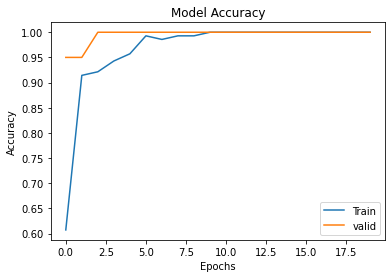

In [14]:
#Plotting model accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'valid'], loc='lower right')
plt.show()

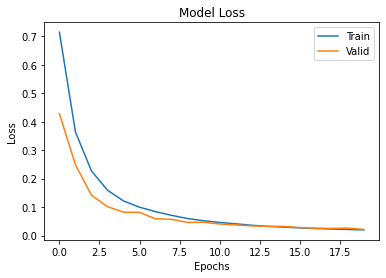

In [15]:
#Plotting model Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()

In [16]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [17]:
predictions = model.predict(x=test_batches, verbose=0)

2022-05-13 22:48:49.965453: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [18]:
np.round(predictions)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [19]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

Confusion matrix function from scikit learn

In [20]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Accent_r):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [21]:
test_batches.class_indices

{'covid': 0, 'normal': 1}

Confusion matrix, without normalization
[[19  1]
 [ 0 20]]


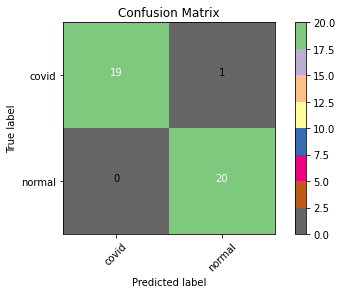

In [22]:
#Plotting the confusion matrix
cm_plot_labels = ['covid','normal']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [23]:
#Converting the data into percentage
cm[0][0] = (cm[0][0]/20)*100
cm[0][1] = (cm[0][1]/20)*100
cm[1][0] = (cm[1][0]/20)*100
cm[1][1] = (cm[1][1]/20)*100


Confusion matrix showuing percentage data

Confusion matrix, without normalization
[[ 95   5]
 [  0 100]]


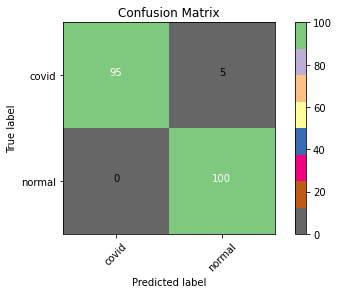

In [24]:
cm_plot_labels = ['covid','normal']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')